# Procesos estocásticos

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl
from scipy import signal

TransferFunction(
array([1. , 0.9]),
array([1.  , 0.02]),
dt=1,
outputs=1, inputs=1)

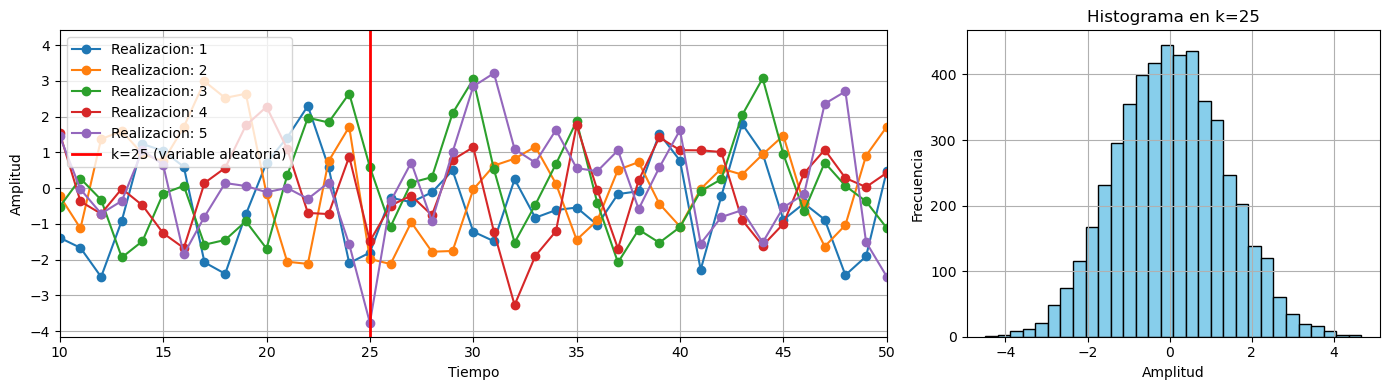

In [22]:
# Proceso estocástico discreto dado por una gaussiana filtrada por un primer orden
N_samples = 100
N_realizations = 5000
w = np.random.randn(N_samples, N_realizations)

G = ctrl.TransferFunction([1, 0.9], [1, 0.02],1)  # Filtro de primer orden
display(G)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), gridspec_kw={'width_ratios': [2, 1]})
for omega in range(5):
    U=w[:,omega]
    _,x = ctrl.forced_response(G,U=U)
    ax1.plot(x,'o-',label=f"Realizacion: {omega+1}")
ax1.axvline(x=25, color='r', linestyle='-', linewidth=2, label='k=25 (variable aleatoria)')
ax1.set_xlabel('Tiempo')
ax1.set_ylabel('Amplitud')
ax1.legend()
ax1.grid()
ax1.set_xlim((10, 50))

# Histograma en k=25 para las 100 realizaciones
valores_k25 = []
for omega in range(N_realizations):
    _, x = ctrl.forced_response(G, U=w[:, omega])
    valores_k25.append(x[25])
ax2.hist(valores_k25, bins=30, color='skyblue', edgecolor='k')
ax2.set_title('Histograma en k=25')
ax2.set_xlabel('Amplitud')
ax2.set_ylabel('Frecuencia')
ax2.grid()

plt.tight_layout()
plt.show()

## Cálculo de autocorrelación y densidad espectral de potencia 

Se calcula la densidad espectral de potencia de un proceso estocástico ergódigo

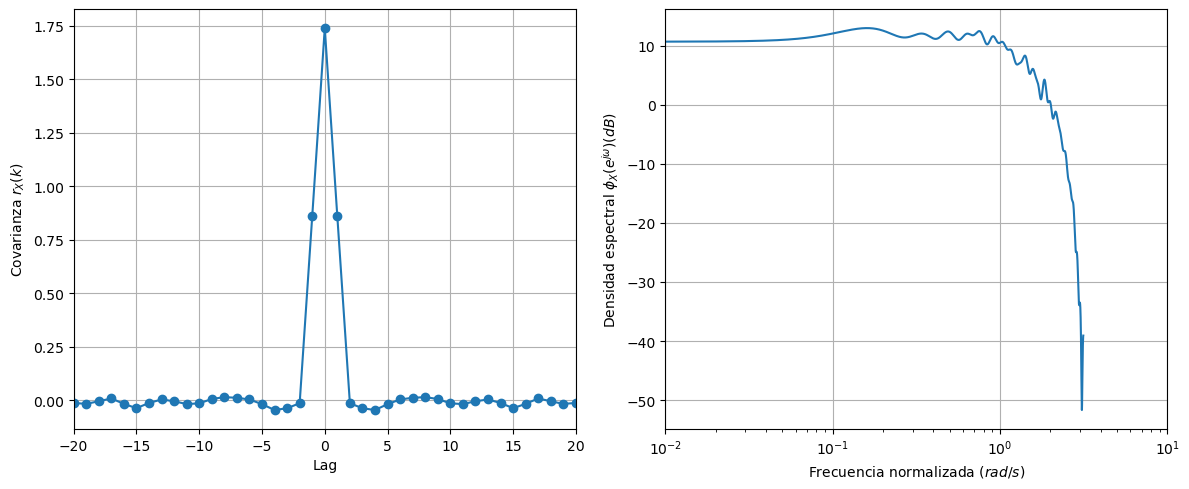

In [ ]:
# Parámetros
N = 10000  # longitud de la señal
np.random.seed(0)
w = np.random.normal(0, 1, N)

# Ahora vamos a calcular el ruido coloreado usando filtros
#p1=.9;
#x = lfilter([0, 1-p1],[p1], w)
x = signal.lfilter([1, 0.9], [1, 0.02], w)

# Autocovarianza estimada
lags = np.arange(-50, 51)
r_x = np.correlate(x - np.mean(x), x - np.mean(x), mode='full') / N
r_x = r_x[N+lags-1]  # centrado en lag 0

# Zero-padding 
rx_padded = np.zeros(N)
center = N // 2
rx_padded[center - 50:center + 51] = r_x


# Espectro (por DFT)
S_x = np.fft.fftshift(np.fft.fft(rx_padded))
w = np.fft.fftshift(np.fft.fftfreq(N, d=1)) * 2 * np.pi  # Frecuencia en radianes
#f = np.linspace(-0.5, 0.5, len(S_x))
S_x_mag = np.abs(S_x)

# Gráficos
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
#plt.stem( lags, r_x, basefmt=" ")
plt.plot( lags, r_x,'o-')
#plt.title("Autocovarianza estimada")
plt.ylabel("Covarianza $r_X(k)$")
plt.xlabel("Lag")
plt.xlim(-20,20)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(w, 10*np.log(S_x_mag))
plt.semilogx()
#plt.title("Densidad espectral de potencia (estimada)")
plt.ylabel("Densidad espectral $\phi_X(e^{jω}) (dB)$")
plt.xlabel("Frecuencia normalizada ($rad/s$)")
plt.xlim(1E-2,10)
plt.grid(True)

plt.tight_layout()
plt.show()


## Ejercicio 1:

Obtener una realización de los siguientes procesos estocásticos. Para cada uno, estimar y graficar:

- La realización
- La función de autocovarianza
- La densidad espectral de potencia (DSP)

### Procesos a analizar:
- Ruido blanco gaussiano
- Ruido coloreado con bajo grado de correlación
- Ruido coloreado con alto grado de correlación


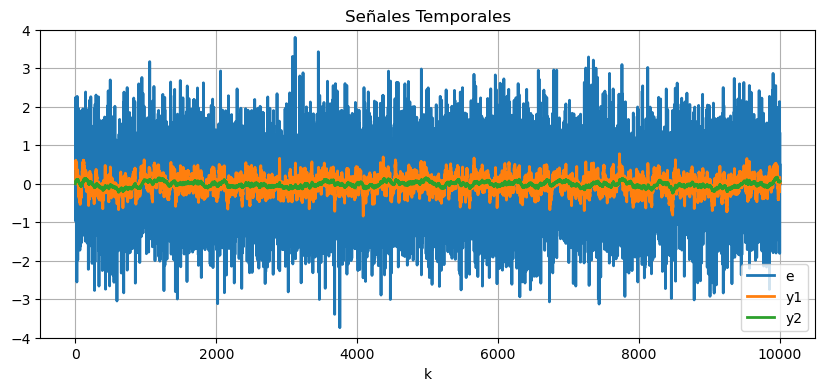

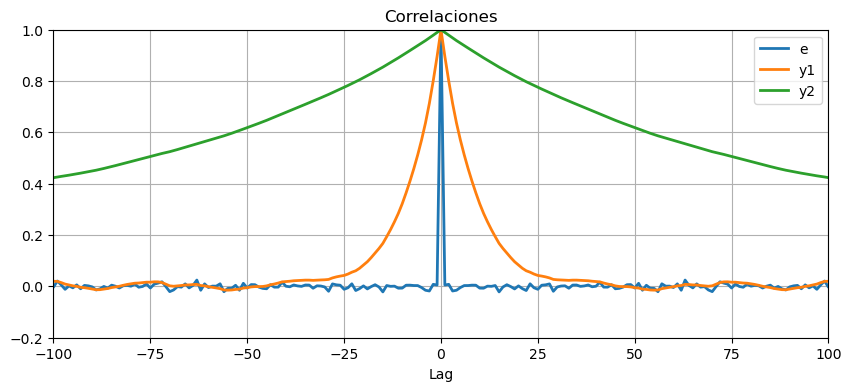

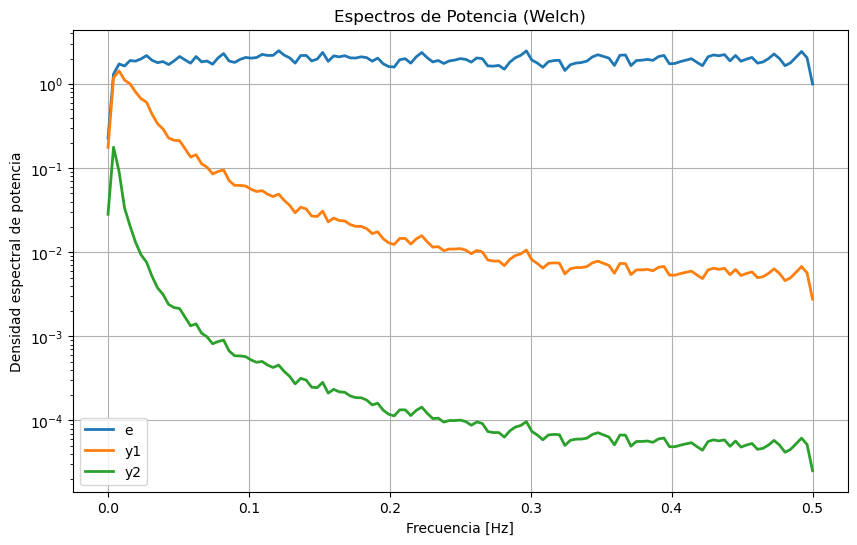

In [ ]:
# Filtrado de Ruido Blanco
# Semilla
np.random.seed(0)

# Datos
n = 10000
e = np.random.randn(n)
T0 = 1

# -------- Filtro 1 --------
p1 = 0.9
A1 = [1, -p1] 
B1 = [0, (1 - p1)]
y1 = signal.lfilter(B1, A1, e)

# -------- Filtro 2 --------
p2 = 0.99
A2 = [1, -p2]
B2 = [0, (1 - p2)]
y2 = signal.lfilter(B2, A2, e)

# %% Señales temporales
plt.figure(figsize=(10,4))
plt.plot(e, label='e', linewidth=2)
plt.plot(y1, label='y1', linewidth=2)
plt.plot(y2, label='y2', linewidth=2)
plt.xlabel("k")
#plt.xlim([2000, 2500])
plt.ylim([-4, 4])
plt.title("Señales Temporales")
plt.legend()
plt.grid()
plt.show()

# %% Correlaciones
xe = signal.correlate(e, e, mode='full') / np.max(np.abs(signal.correlate(e, e)))
xy1 = signal.correlate(y1, y1, mode='full') / np.max(np.abs(signal.correlate(y1, y1)))
xy2 = signal.correlate(y2, y2, mode='full') / np.max(np.abs(signal.correlate(y2, y2)))

lags = np.arange(-n+1, n)
delta = 100

plt.figure(figsize=(10,4))
plt.plot(lags, xe, label='e', linewidth=2)
plt.plot(lags, xy1, label='y1', linewidth=2)
plt.plot(lags, xy2, label='y2', linewidth=2)
plt.xlabel("Lag")
plt.xlim([-delta, delta])
plt.ylim([-0.2, 1])
plt.title("Correlaciones")
plt.legend()
plt.grid()
plt.show()

# Espectros (estimación espectral con Welch -> Periodograma)
# La estimación de Welch promedia periodogramas de segmentos solapados de la señal
# para reducir la varianza de la estimación.
# El método de Wiener-Khinchin establece que la DFT de la autocorrelación es igual a la densidad espectral de potencia.
# La DSP obtenida de esta manera tiene mayor varianza pero también aporta más detalles a diferencia del método de Welch.
w, Pe = signal.welch(e, fs=1/T0, nperseg=256)
_, Py1 = signal.welch(y1, fs=1/T0, nperseg=256)
_, Py2 = signal.welch(y2, fs=1/T0, nperseg=256)

plt.figure(figsize=(10,6))
plt.semilogy(w, Pe, label="e", linewidth=2)
plt.semilogy(w, Py1, label="y1", linewidth=2)
plt.semilogy(w, Py2, label="y2", linewidth=2)
plt.title("Espectros de Potencia (Welch)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Densidad espectral de potencia")
plt.legend()
plt.grid()
plt.show()


## Ejercicio 2

Generar una realización de:
- Un proceso de **ruido blanco gaussiano** $X$
- Un proceso **binario aleatorio** (BRP) $Y = \operatorname{sign}(X)
  $

Calcular y graficar para ambos procesos:
- La **media** y **varianza**
- La **función de autocovarianza** $r(k)$
- La **densidad espectral de potencia**

Comparar las propiedades estadísticas de ambos procesos. En particular, discutir cómo la operación no lineal de cuantización afecta la autocovarianza y el contenido espectral del proceso resultante.
